# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


---
#### Embedding layer background

[[[-0.02263385  0.04498615]
  [ 0.00536595  0.00927667]
  [-0.00979977 -0.00946053]
  [ 0.00637377  0.0326632 ]
  [-0.00757368 -0.02196393]
  [-0.04004828  0.0141809 ]
  [-0.0172526   0.04202836]
  [ 0.04326487 -0.04736057]
  [-0.04486425 -0.02252822]
  [-0.04112552  0.02595988]]]


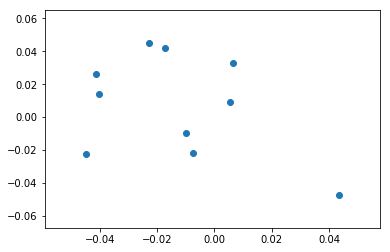

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

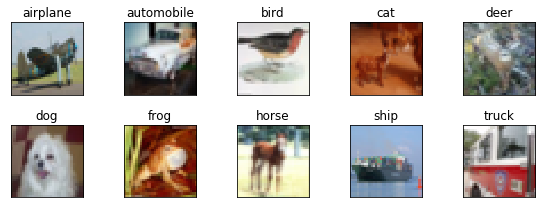

In [5]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [8]:
print(X_train[0].shape)

(32, 32, 3)


### 2. Define model

#### Generator

Our generator is a simple fully connected neural network with three hidden layer, ReLU activation and Batch Normalization.

In [9]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x256
generator.add(Dense(2*2*256, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 256)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x128
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x64
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x32
generator.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [10]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [11]:
# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

#### Conditional model visualization

In [12]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

#### Discriminator

Our discriminator is a simple fully connected neural network with three hidden layer and ReLU activation.

In [13]:
# imagem shape 32x32x3
img_shape = X_train[0].shape
img_shape_flat = 32*32*3

# Discriminator network
discriminator = Sequential()

discriminator.add(Reshape(X_train[0].shape, input_shape=(img_shape_flat,)))

# Conv 1: 16x16x32
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())
discriminator.add(LeakyReLU(0.2))

# Output
discriminator.add(Dense(1, activation='sigmoid'))


#### Discriminator model visualization

In [14]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

#### Conditional D model

$x$ and $y$ are presented as inputs

In [15]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_shape_flat)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_shape_flat,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [16]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 3072)      30720       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3072)         0           embedding_3[0][0]                
__________________________________________________________________________________________________
multiply_2

### 3. Compile model

#### Compile discriminator

In [17]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [18]:
discriminator.trainable = False

fake_img = generator([z, label])
fake_img_flat = Reshape((img_shape_flat, ))(fake_img)
validity = discriminator([fake_img_flat, label])

d_g = Model([z, label], validity)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [19]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    494507      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3072)         0           model_1[1][0]                    
__________

### 4. Fit model


epoch = 1/100, d_loss=0.308, g_loss=0.240                                                                                                                      


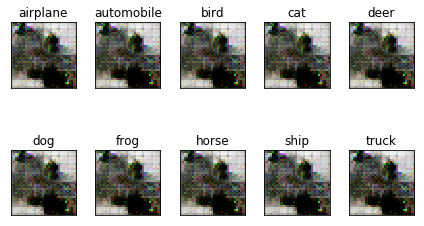

epoch = 2/100, d_loss=0.531, g_loss=0.904                                                                                                                      
epoch = 3/100, d_loss=0.569, g_loss=1.150                                                                                                                      
epoch = 4/100, d_loss=0.608, g_loss=0.761                                                                                                                      
epoch = 5/100, d_loss=0.275, g_loss=0.109                                                                                                                      
epoch = 6/100, d_loss=0.250, g_loss=0.126                                                                                                                      
epoch = 7/100, d_loss=0.279, g_loss=0.162                                                                                                                      
epoch = 8/100, d_loss=0.283, g_loss=0.12

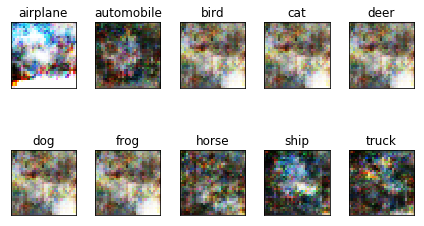

epoch = 12/100, d_loss=0.292, g_loss=0.581                                                                                                                      
epoch = 13/100, d_loss=0.524, g_loss=0.597                                                                                                                      
epoch = 14/100, d_loss=0.317, g_loss=0.665                                                                                                                      
epoch = 15/100, d_loss=0.351, g_loss=0.683                                                                                                                      
epoch = 16/100, d_loss=0.334, g_loss=0.443                                                                                                                      
epoch = 17/100, d_loss=0.319, g_loss=0.178                                                                                                                      
epoch = 18/100, d_loss=0.237, g_lo

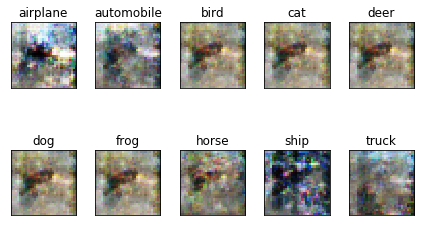

epoch = 22/100, d_loss=0.334, g_loss=0.251                                                                                                                      
epoch = 23/100, d_loss=0.371, g_loss=0.217                                                                                                                      
epoch = 24/100, d_loss=0.342, g_loss=0.371                                                                                                                      
epoch = 25/100, d_loss=0.384, g_loss=0.736                                                                                                                      
epoch = 26/100, d_loss=0.384, g_loss=0.437                                                                                                                      
epoch = 27/100, d_loss=0.328, g_loss=0.789                                                                                                                      
epoch = 28/100, d_loss=0.359, g_lo

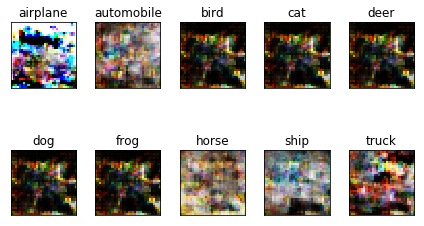

epoch = 32/100, d_loss=0.380, g_loss=0.493                                                                                                                      
epoch = 33/100, d_loss=0.339, g_loss=0.447                                                                                                                      
epoch = 34/100, d_loss=0.393, g_loss=0.590                                                                                                                      
epoch = 35/100, d_loss=0.282, g_loss=0.537                                                                                                                      
epoch = 36/100, d_loss=0.356, g_loss=0.466                                                                                                                      
epoch = 37/100, d_loss=0.332, g_loss=0.976                                                                                                                      
epoch = 38/100, d_loss=0.351, g_lo

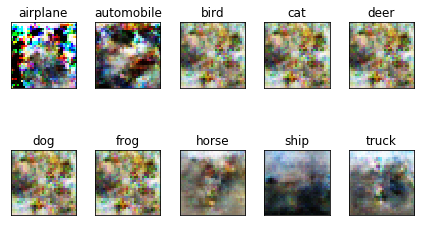

epoch = 42/100, d_loss=0.311, g_loss=0.645                                                                                                                      
epoch = 43/100, d_loss=0.294, g_loss=0.557                                                                                                                      
epoch = 44/100, d_loss=0.323, g_loss=0.610                                                                                                                      
epoch = 45/100, d_loss=0.358, g_loss=0.444                                                                                                                      
epoch = 46/100, d_loss=0.344, g_loss=0.456                                                                                                                      
epoch = 47/100, d_loss=0.374, g_loss=0.527                                                                                                                      
epoch = 48/100, d_loss=0.403, g_lo

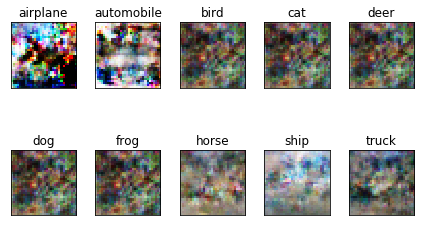

epoch = 52/100, d_loss=0.338, g_loss=0.252                                                                                                                      
epoch = 53/100, d_loss=0.342, g_loss=0.557                                                                                                                      
epoch = 54/100, d_loss=0.325, g_loss=0.510                                                                                                                      
epoch = 55/100, d_loss=0.282, g_loss=0.302                                                                                                                      
epoch = 56/100, d_loss=0.288, g_loss=0.588                                                                                                                      
epoch = 57/100, d_loss=0.277, g_loss=0.816                                                                                                                      
epoch = 58/100, d_loss=0.392, g_lo

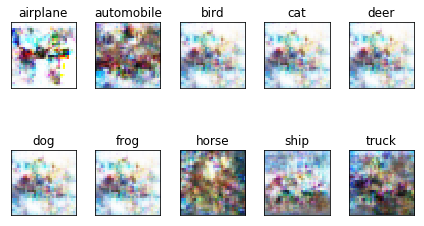

epoch = 62/100, d_loss=0.268, g_loss=0.396                                                                                                                      
epoch = 63/100, d_loss=0.286, g_loss=0.492                                                                                                                      
epoch = 64/100, d_loss=0.294, g_loss=0.887                                                                                                                      
epoch = 65/100, d_loss=0.284, g_loss=0.375                                                                                                                      


In [ ]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch.reshape(-1, 32*32*3), real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake.reshape(-1, 32*32*3), random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)